In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import mne
import mne_nirs

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

In [2]:
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir).load_data()
raw_intensity.resample(0.7)

Loading /Users/bryan/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 2082 (2972.9 s), ~981 kB, data loaded>

In [3]:
raw_intensity.annotations

<Annotations | 92 segments: 1.0 (30), 15.0 (2), 2.0 (30), 3.0 (30)>

In [4]:
raw_intensity.annotations.rename({'1.0': 'Control',
                                  '2.0': 'Tapping_Left',
                                  '3.0': 'Tapping_Right'})
raw_intensity.annotations.delete(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations.set_durations(5)

<Annotations | 90 segments: Control (30), Tapping_Left (30), Tapping_Right ...>

In [5]:
raw_intensity.annotations

<Annotations | 90 segments: Control (30), Tapping_Left (30), Tapping_Right ...>

In [6]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

In [7]:
short_chs = get_short_channels(raw_haemo)

In [8]:
short_chs

<RawNIRX | Participant-1, 16 x 2082 (2972.9 s), ~294 kB, data loaded>

In [9]:
raw_haemo = get_long_channels(raw_haemo)

In [10]:
raw_haemo

<RawNIRX | Participant-1, 40 x 2082 (2972.9 s), ~706 kB, data loaded>

In [12]:
from mne.preprocessing.nirs import source_detector_distances


In [13]:
dists = source_detector_distances(raw_haemo.info)

In [14]:
dists

array([0.0392934 , 0.0392934 , 0.03890886, 0.03890886, 0.04089411,
       0.04089411, 0.03717697, 0.03717697, 0.03760152, 0.03760152,
       0.03703957, 0.03703957, 0.04032053, 0.04032053, 0.03666452,
       0.03666452, 0.04068731, 0.04068731, 0.03402734, 0.03402734,
       0.03902399, 0.03902399, 0.0392201 , 0.0392201 , 0.04089535,
       0.04089535, 0.03696921, 0.03696921, 0.03707284, 0.03707284,
       0.03696964, 0.03696964, 0.04042705, 0.04042705, 0.03721506,
       0.03721506, 0.04066576, 0.04066576, 0.03344405, 0.03344405])

In [16]:
paul_raw_intensity = mne.io.read_raw_snirf("./paul2.snirf")
paul_raw_od = mne.preprocessing.nirs.optical_density(paul_raw_intensity)
paul_raw_haemo = mne.preprocessing.nirs.beer_lambert_law(paul_raw_od, ppf=0.1)

Loading /Users/bryan/work/dsp/paul2.snirf
Reading 0 ... 4840  =      0.000 ...   484.000 secs...


In [17]:
paul_dists = source_detector_distances(paul_raw_haemo.info)

In [18]:
paul_dists


array([0.04340541, 0.0338746 , 0.03665137, 0.05440692, 0.02883645,
       0.03466972, 0.05034476, 0.04085377, 0.04342203, 0.0346696 ,
       0.03668378, 0.05444247, 0.0293802 , 0.03500686, 0.05091747,
       0.04132342, 0.04340541, 0.0338746 , 0.03665137, 0.05440692,
       0.02883645, 0.03466972, 0.05034476, 0.04085377, 0.04342203,
       0.0346696 , 0.03668378, 0.05444247, 0.0293802 , 0.03500686,
       0.05091747, 0.04132342])

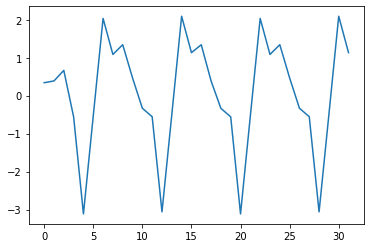

In [24]:
ch_distances = np.array([4, 3, 3, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3])
diff = paul_dists * 100 - ch_distances
plt.plot(diff)

In [25]:
diff

array([ 0.34054075,  0.38746024,  0.66513658, -0.55930838, -3.11635488,
       -0.53302804,  2.03447589,  1.08537651,  1.34220273,  0.46696024,
       -0.33162193, -0.55575333, -3.06198038, -0.49931384,  2.09174743,
        1.13234237,  1.34054075,  0.38746024, -0.33486342, -0.55930838,
       -3.11635488, -0.53302804,  2.03447589,  1.08537651,  1.34220273,
        0.46696024, -0.33162193, -0.55575333, -3.06198038, -0.49931384,
        2.09174743,  1.13234237])

In [28]:
paul_raw_haemo.info["chs"]

[{'loc': array([-5.357950e-02,  5.997455e-02,  2.315135e-02, -6.072260e-02,
          6.472820e-02,  3.216800e-03, -4.643640e-02,  5.522090e-02,
          4.308590e-02,  7.350000e+02,           nan,           nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 1100 (FIFFV_FNIRS_CH),
  'coil_type': 300 (FIFFV_COIL_FNIRS_HBO),
  'unit': 6 (FIFF_UNIT_MOL),
  'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
  'ch_name': 'S1_D1 hbo',
  'scanno': 1,
  'logno': 1},
 {'loc': array([-5.045000e-02,  6.837725e-02,  1.617945e-02, -6.072260e-02,
          6.472820e-02,  3.216800e-03, -4.017740e-02,  7.202630e-02,
          2.914210e-02,  7.350000e+02,           nan,           nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 1100 (FIFFV_FNIRS_CH),
  'coil_type': 300 (FIFFV_COIL_FNIRS_HBO),
  'unit': 6 (FIFF_UNIT_MOL),
  'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
  'ch_name': 'S1_D2 hbo',
  'scanno': 2,
  'logno': 2},
 {'loc': array([-4.68307e-02,  7

In [29]:
paul_raw_intensity.annotations

<Annotations | 132 segments: counting7 (132)>

In [33]:
paul_raw_haemo.info["chs"][0]["loc"][3:9].reshape(2, 3)

array([[-0.0607226,  0.0647282,  0.0032168],
       [-0.0464364,  0.0552209,  0.0430859]])

In [34]:
len(paul_raw_haemo.info["chs"])

32

In [37]:
paul_raw_haemo.info["chs"][15]

{'loc': array([1.986435e-02, 7.555780e-02, 4.221425e-02, 2.293410e-02,
        6.346550e-02, 5.868420e-02, 1.679460e-02, 8.765010e-02,
        2.574430e-02, 7.350000e+02,          nan,          nan]),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'range': 1.0,
 'cal': 1.0,
 'kind': 1100 (FIFFV_FNIRS_CH),
 'coil_type': 300 (FIFFV_COIL_FNIRS_HBO),
 'unit': 6 (FIFF_UNIT_MOL),
 'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
 'ch_name': 'S4_D8 hbo',
 'scanno': 16,
 'logno': 16}

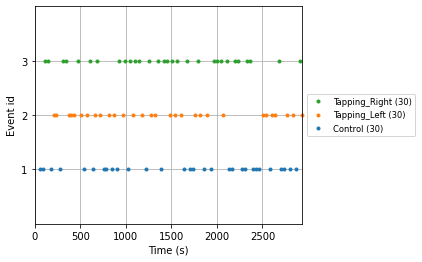

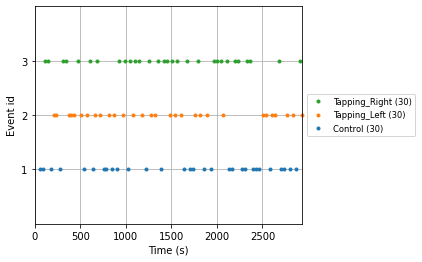

In [38]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info['sfreq'])

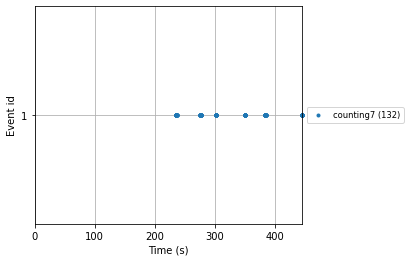

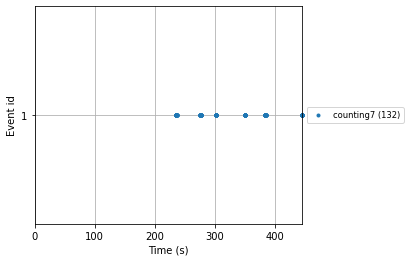

In [39]:
events, event_dict = mne.events_from_annotations(paul_raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=paul_raw_haemo.info['sfreq'])

In [41]:
events.shape

(132, 3)

In [43]:
event_dict

{'counting7': 1}

In [44]:
events[0]

array([2352,    0,    1])

Events correspond to specific time points in raw data, such as triggers, experimental condition events, etc. MNE-Python represents events with integers stored in NumPy arrays of shape (n_events, 3). The first column contains the event onset (in samples) with first_samp included. The last column contains the event code. The second column contains the signal value of the immediately preceding sample, and reflects the fact that event arrays sometimes originate from analog voltage channels (“trigger channels” or “stim channels”). In most cases, the second column is all zeros and can be ignored. Event arrays can be created with mne.make_fixed_length_events(), mne.read_events(), and mne.find_events(). See Parsing events from raw data for a short tutorial. See also annotations.

In [46]:
2352 / 10

235.2

In [48]:
events[:10]

array([[2352,    0,    1],
       [2352,    0,    1],
       [2353,    0,    1],
       [2353,    0,    1],
       [2354,    0,    1],
       [2354,    0,    1],
       [2355,    0,    1],
       [2355,    0,    1],
       [2356,    0,    1],
       [2356,    0,    1]])

In [49]:
events[:20]

array([[2352,    0,    1],
       [2352,    0,    1],
       [2353,    0,    1],
       [2353,    0,    1],
       [2354,    0,    1],
       [2354,    0,    1],
       [2355,    0,    1],
       [2355,    0,    1],
       [2356,    0,    1],
       [2356,    0,    1],
       [2357,    0,    1],
       [2357,    0,    1],
       [2358,    0,    1],
       [2358,    0,    1],
       [2359,    0,    1],
       [2359,    0,    1],
       [2360,    0,    1],
       [2360,    0,    1],
       [2361,    0,    1],
       [2361,    0,    1]])

In [50]:
len(events)

132

In [51]:
events[:50]

array([[2352,    0,    1],
       [2352,    0,    1],
       [2353,    0,    1],
       [2353,    0,    1],
       [2354,    0,    1],
       [2354,    0,    1],
       [2355,    0,    1],
       [2355,    0,    1],
       [2356,    0,    1],
       [2356,    0,    1],
       [2357,    0,    1],
       [2357,    0,    1],
       [2358,    0,    1],
       [2358,    0,    1],
       [2359,    0,    1],
       [2359,    0,    1],
       [2360,    0,    1],
       [2360,    0,    1],
       [2361,    0,    1],
       [2361,    0,    1],
       [2362,    0,    1],
       [2362,    0,    1],
       [2754,    0,    1],
       [2754,    0,    1],
       [2755,    0,    1],
       [2755,    0,    1],
       [2756,    0,    1],
       [2756,    0,    1],
       [2757,    0,    1],
       [2757,    0,    1],
       [2758,    0,    1],
       [2758,    0,    1],
       [2759,    0,    1],
       [2759,    0,    1],
       [2760,    0,    1],
       [2760,    0,    1],
       [2761,    0,    1],
 

In [54]:
paul_raw_intensity.annotations[0]

OrderedDict([('onset', 235.2),
             ('duration', 10.0),
             ('description', 'counting7'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [55]:
paul_raw_intensity.annotations[0].description = "hi"

In [56]:
paul_raw_intensity.annotations[0]

OrderedDict([('onset', 235.2),
             ('duration', 10.0),
             ('description', 'counting7'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [63]:
paul_raw_intensity.annotations.description[0] = "hi"

In [64]:
paul_raw_intensity.annotations[0]

OrderedDict([('onset', 235.2),
             ('duration', 10.0),
             ('description', 'hi'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [67]:
num_annotations = len(paul_raw_intensity.annotations) 
print(f"{num_annotations = }")
# paul_raw_intensity.annotations[0]
for i in range(num_annotations):
    if i%2 == 0:
        paul_raw_intensity.annotations.description[i] = "on"
    else:
        paul_raw_intensity.annotations.description[i] = "off"

num_annotations = 132


In [68]:
paul_raw_intensity.annotations[0]

OrderedDict([('onset', 235.2),
             ('duration', 10.0),
             ('description', 'on'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [69]:
paul_raw_intensity.annotations[1]


OrderedDict([('onset', 235.2),
             ('duration', 10.0),
             ('description', 'off'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [70]:
paul_raw_intensity.annotations[2]

OrderedDict([('onset', 235.3),
             ('duration', 10.0),
             ('description', 'on'),
             ('orig_time',
              datetime.datetime(2023, 9, 13, 14, 9, 5, tzinfo=datetime.timezone.utc))])

In [74]:
import scipy.io
data = scipy.io.loadmat("./paul.nirs")


In [75]:
events = data['StimDesign'][0][0][1].flatten()


In [76]:
events

array([235.2, 275.4, 301.3, 349.6, 383.3, 444.3])

In [78]:
durs = events[1:] - events[:-1]
durs

array([40.2, 25.9, 48.3, 33.7, 61. ])

In [79]:
timings = data['t'].flatten()


In [80]:
timings

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.838e+02, 4.839e+02,
       4.840e+02])

In [81]:
len(timings)

4841

In [82]:
timings[:5]


array([0. , 0.1, 0.2, 0.3, 0.4])

In [83]:
on_off = np.zeros_like(timings)
events_sec = np.array([np.where(e==timings)[0][0] for e in events])


In [84]:
events_sec

array([2352, 2754, 3013, 3496, 3833, 4443])

In [85]:
np.where(events[0]==timings)

(array([2352]),)

In [86]:
timings[2352]

235.2

In [87]:
events_sec = np.concatenate((events_sec[:2], events_sec[3:]))


In [88]:
events_sec

array([2352, 2754, 3496, 3833, 4443])

In [90]:
paul_raw_haemo.times[:10]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [91]:
data_subset = raw_haemo.copy().pick(picks=range(2))


In [92]:
data_subset

<RawNIRX | Participant-1, 2 x 2082 (2972.9 s), ~54 kB, data loaded>

In [93]:
paul_raw_intensity

<RawSNIRF | paul2.snirf, 32 x 4841 (484.0 s), ~49 kB, data not loaded>

In [94]:
design_matrix = make_first_level_design_matrix(raw_haemo,
                                               drift_model='cosine',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=5.0)

In [99]:
len(raw_haemo.times)

2082

In [100]:
design_matrix.shape

(2082, 33)

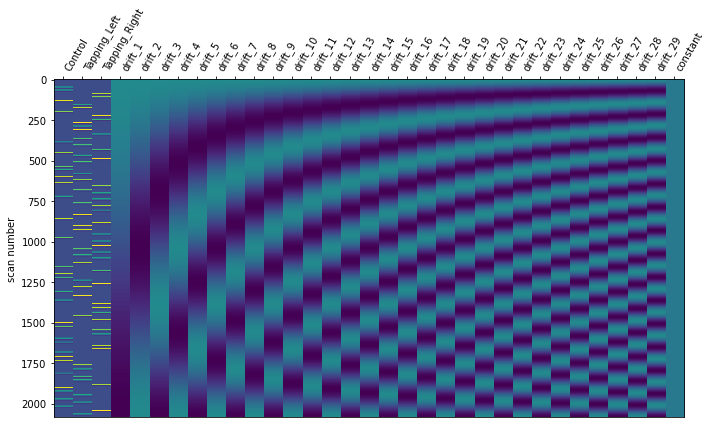

In [101]:
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(design_matrix, ax=ax1)

Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']


Text(0, 0.5, 'Amplitude')

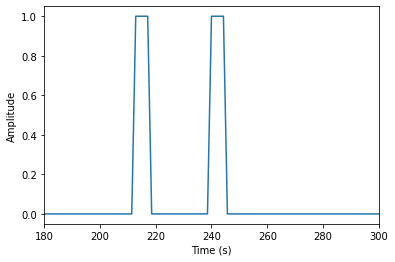

In [108]:
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=5.0)
plt.plot(raw_intensity.times, s[:, 1]) # stimulus
# plt.plot(design_matrix['Tapping_Left']) # expected response
plt.xlim(180, 300)
# plt.legend(["Stimulus", "Expected Response"])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

In [107]:
design_matrix['Tapping_Left'][220]

0.830238015357182

In [109]:
design_matrix.keys()

Index(['Control', 'Tapping_Left', 'Tapping_Right', 'drift_1', 'drift_2',
       'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8',
       'drift_9', 'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14',
       'drift_15', 'drift_16', 'drift_17', 'drift_18', 'drift_19', 'drift_20',
       'drift_21', 'drift_22', 'drift_23', 'drift_24', 'drift_25', 'drift_26',
       'drift_27', 'drift_28', 'drift_29', 'constant'],
      dtype='object')

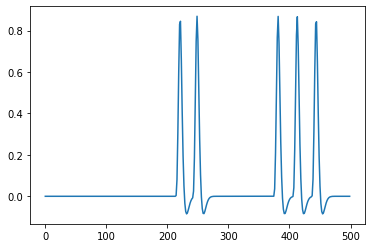

In [117]:
plt.plot(design_matrix["Tapping_Left"][:500])

In [118]:
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)

In [123]:
est = glm_est.to_dataframe()

In [124]:
est

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Control,33.0,1.207667e-10,7.225389e-01,2.317785e-06,0.358114,8.300307e-07,1,1,hbo,False,S1_D1 hbo
1,Tapping_Left,33.0,1.207667e-10,3.284273e-03,2.321888e-06,3.169791,7.359901e-06,1,1,hbo,True,S1_D1 hbo
2,Tapping_Right,33.0,1.207667e-10,1.739907e-10,2.322691e-06,9.074154,2.107646e-05,1,1,hbo,True,S1_D1 hbo
3,constant,33.0,1.207667e-10,4.498733e-02,5.260490e-07,-2.083923,-1.096246e-06,1,1,hbo,True,S1_D1 hbo
4,drift_1,33.0,1.207667e-10,2.020770e-20,2.196767e-05,20.616079,4.528873e-04,1,1,hbo,True,S1_D1 hbo
...,...,...,...,...,...,...,...,...,...,...,...,...
61,drift_5,33.0,9.608925e-12,3.028197e-01,6.205099e-06,-1.046754,-6.495213e-06,1,1,hbr,False,S1_D1 hbr
62,drift_6,33.0,9.608925e-12,5.397096e-11,6.196291e-06,9.525077,5.902014e-05,1,1,hbr,True,S1_D1 hbr
63,drift_7,33.0,9.608925e-12,5.399978e-04,6.213903e-06,-3.832409,-2.381422e-05,1,1,hbr,True,S1_D1 hbr
64,drift_8,33.0,9.608925e-12,6.614204e-01,6.204205e-06,0.441933,2.741843e-06,1,1,hbr,False,S1_D1 hbr


In [125]:
design_matrix.shape

(2082, 33)

In [129]:
paul_raw_haemo.ch_names

['S1_D1 hbo',
 'S1_D2 hbo',
 'S1_D3 hbo',
 'S1_D4 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S2_D3 hbo',
 'S2_D4 hbo',
 'S3_D5 hbo',
 'S3_D6 hbo',
 'S3_D7 hbo',
 'S3_D8 hbo',
 'S4_D5 hbo',
 'S4_D6 hbo',
 'S4_D7 hbo',
 'S4_D8 hbo',
 'S1_D1 hbr',
 'S1_D2 hbr',
 'S1_D3 hbr',
 'S1_D4 hbr',
 'S2_D1 hbr',
 'S2_D2 hbr',
 'S2_D3 hbr',
 'S2_D4 hbr',
 'S3_D5 hbr',
 'S3_D6 hbr',
 'S3_D7 hbr',
 'S3_D8 hbr',
 'S4_D5 hbr',
 'S4_D6 hbr',
 'S4_D7 hbr',
 'S4_D8 hbr']

In [130]:
len(paul_raw_haemo.ch_names)

32

In [131]:
paul_raw_intensity.ch_names

['S1_D1 735',
 'S1_D2 735',
 'S1_D3 735',
 'S1_D4 735',
 'S2_D1 735',
 'S2_D2 735',
 'S2_D3 735',
 'S2_D4 735',
 'S3_D5 735',
 'S3_D6 735',
 'S3_D7 735',
 'S3_D8 735',
 'S4_D5 735',
 'S4_D6 735',
 'S4_D7 735',
 'S4_D8 735',
 'S1_D1 850',
 'S1_D2 850',
 'S1_D3 850',
 'S1_D4 850',
 'S2_D1 850',
 'S2_D2 850',
 'S2_D3 850',
 'S2_D4 850',
 'S3_D5 850',
 'S3_D6 850',
 'S3_D7 850',
 'S3_D8 850',
 'S4_D5 850',
 'S4_D6 850',
 'S4_D7 850',
 'S4_D8 850']

In [132]:
paul_raw_haemo

<RawSNIRF | paul2.snirf, 32 x 4841 (484.0 s), ~1.2 MB, data loaded>

<AxesSubplot:xlabel='Condition', ylabel='Theta'>

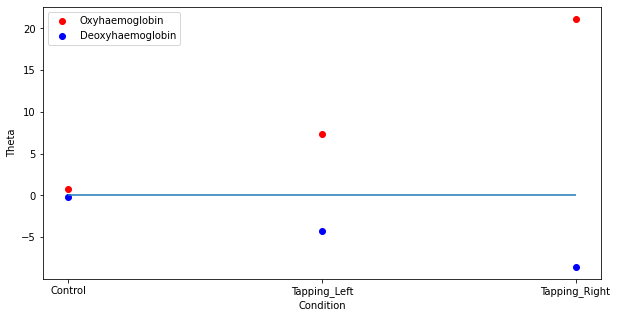

In [133]:
glm_est.scatter()
#these are the fitted theta values

In [ ]:
design_matrix = make_first_level_design_matrix(raw_haemo,
                                               drift_model='cosine',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=5.0)

In [136]:
raw_haemo.annotations[0]

OrderedDict([('onset', 61.824),
             ('duration', 5.0),
             ('description', 'Control'),
             ('orig_time',
              datetime.datetime(2019, 11, 2, 13, 16, 16, 567000, tzinfo=datetime.timezone.utc))])

In [137]:
paul_raw_haemo.annotations

<Annotations | 132 segments: counting7 (132)>

In [138]:
test = paul_raw_haemo.copy()

In [139]:
test.annotations

<Annotations | 132 segments: counting7 (132)>

In [ ]:
test.annotations

In [140]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: Win32NT, CREATED on: Mon, 11 Sep 2023 15:33:37 GMT',
 '__version__': '1.0',
 '__globals__': [],
 'd': array([[37722., 38173., 21970., ..., 35591., 40519., 13684.],
        [34281., 39365., 22480., ..., 37092., 35577., 17520.],
        [33197., 39664., 21464., ..., 36384., 34861., 19841.],
        ...,
        [26567., 30044., 11563., ...,  2881.,  6870.,  6762.],
        [26552., 29947., 11562., ...,  2892.,  6844.,  6750.],
        [26457., 29648., 11507., ...,  2893.,  6801.,  6715.]]),
 'aux': array([[ 66.,  32.,  55., ...,  27., 105.,  92.],
        [ 66.,  32.,  55., ...,  27., 151.,  52.],
        [ 66.,  32.,  55., ...,  27.,   5., 212.],
        ...,
        [ 81.,  32.,  57., ...,  26., 253., 216.],
        [ 81.,  32.,  57., ...,  26., 204., 165.],
        [ 81.,  32.,  57., ...,  26., 172., 165.]]),
 't': array([[0.000e+00],
        [1.000e-01],
        [2.000e-01],
        ...,
        [4.838e+02],
        [4.839e+02],
       

In [141]:
events_sec

array([2352, 2754, 3496, 3833, 4443])

In [150]:
onsets = timings[events_sec]
durations = onsets[1:] - onsets[:-1]
onsets = list(onsets)
durations = list(durations)
durations.append(timings[-1] - onsets[-1])
descriptions = []
for i in range(len(onsets)):
    if i%2==0:
        descriptions.append("on")
    else:
        descriptions.append("off")
    
    
assert len(onsets) == len(durations)
assert len(descriptions) == len(onsets)

In [152]:
descriptions

['on', 'off', 'on', 'off', 'on']

In [147]:
timings[-1] - onsets[-1]

39.69999999999999

In [153]:
annotations = mne.Annotations(onset=onsets, duration=durations,
            description=descriptions)


In [155]:
test.set_annotations(annotations)

<RawSNIRF | paul2.snirf, 32 x 4841 (484.0 s), ~1.2 MB, data loaded>

In [156]:
test

<RawSNIRF | paul2.snirf, 32 x 4841 (484.0 s), ~1.2 MB, data loaded>

In [157]:
test.annotations

<Annotations | 5 segments: off (2), on (3)>

In [158]:
paul_design_matrix = make_first_level_design_matrix(test,
                                               drift_model='cosine',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=5.0)

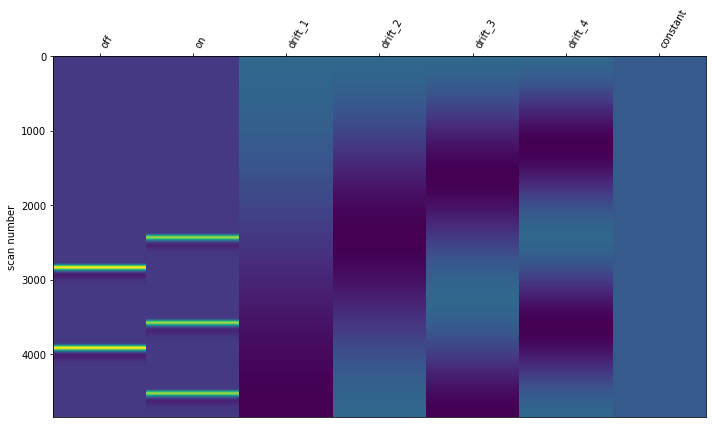

In [160]:
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(paul_design_matrix, ax=ax1)

In [162]:
paul_design_matrix["test"] = paul_design_matrix["on"]

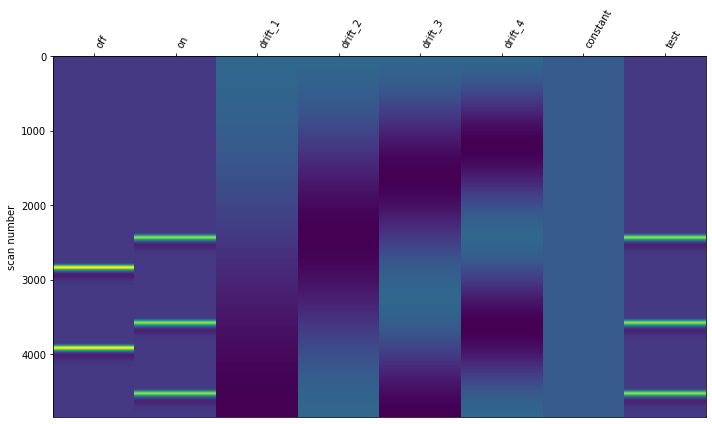

In [163]:
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(paul_design_matrix, ax=ax1)

How do we set the high pass value?

> See the nilearn documentation for recommendations on setting these values. In short, they suggest “The cutoff period (1/high_pass) should be set as the longest period between two trials of the same condition multiplied by 2. For instance, if the longest period is 32s, the high_pass frequency shall be 1/64 Hz ~ 0.016 Hz”.



From ChatGPT:

From your annotations, it seems like you have both "on" and "off" conditions. If only the "on" conditions matter for determining the high pass value, then we should only consider those. Now, the interval or period between the "on" conditions is what you should look at.

Let's assume the "onset" value to be the beginning of that condition. As per your annotations:

The first "on" event starts at 235.2.
The second "on" event starts at 349.6.
The last "on" event starts at 444.3.
The period between the first and second "on" events: 349.6 - 235.2 = 114.4 seconds. The period between the second and last "on" events: 444.3 - 349.6 = 94.7 seconds.

The longest period here is 114.4 seconds. To determine the high pass value, take twice this value (as per the nilearn recommendation), and then take the inverse:

High pass cutoff = 1 / (2 * 114.4) = ~ 0.00437 Hz

So you could set high_pass = 0.00437 in your make_first_level_design_matrix() function. However, the exact value might depend on the rest of your experiment design. This calculation only considers the "on" conditions and assumes that the onset values mark the beginning of these conditions. Please adjust the calculation as needed if these assumptions do not hold for your experiment design.

Let's verify this math.

In [182]:
349.6 - 235.2

114.40000000000003

In [183]:
444.3 - 349.6

94.69999999999999

In [186]:
high_pass = 1/(2*114.40000000000003) 
high_pass

0.004370629370629369

In [179]:
durations

[40.19999999999999,
 74.20000000000005,
 33.69999999999999,
 61.0,
 39.69999999999999]

In [181]:
[print(x) for x in annotations]

OrderedDict([('onset', 235.2), ('duration', 40.19999999999999), ('description', 'on'), ('orig_time', None)])
OrderedDict([('onset', 275.4), ('duration', 74.20000000000005), ('description', 'off'), ('orig_time', None)])
OrderedDict([('onset', 349.6), ('duration', 33.69999999999999), ('description', 'on'), ('orig_time', None)])
OrderedDict([('onset', 383.3), ('duration', 61.0), ('description', 'off'), ('orig_time', None)])
OrderedDict([('onset', 444.3), ('duration', 39.69999999999999), ('description', 'on'), ('orig_time', None)])


[None, None, None, None, None]

In [188]:
stim_dur = min(durations)
stim_dur

33.69999999999999

num_annotations = 5
first_col_name = 'on'
first_col_name = 'off'
first_col_name = 'on'
first_col_name = 'off'
first_col_name = 'on'


(5, 32)

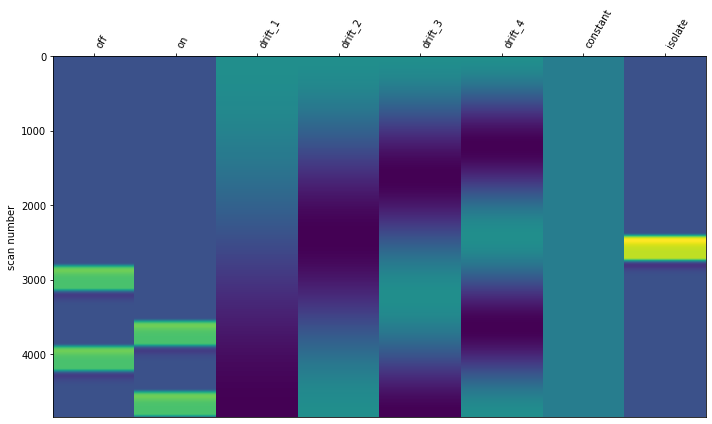

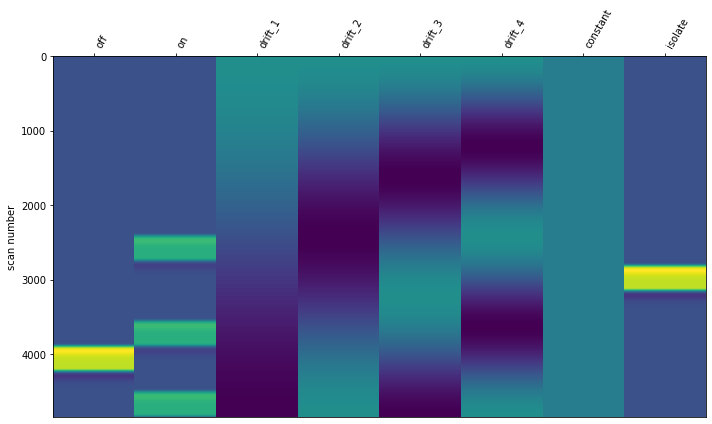

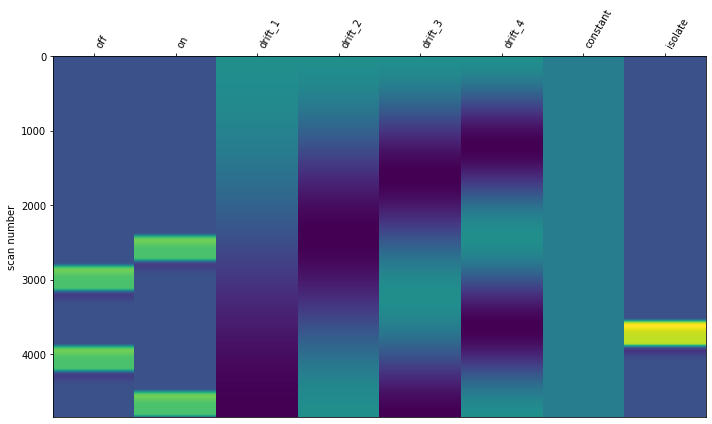

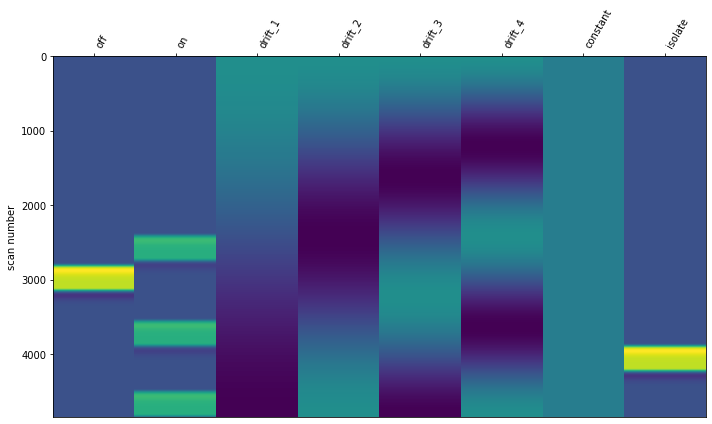

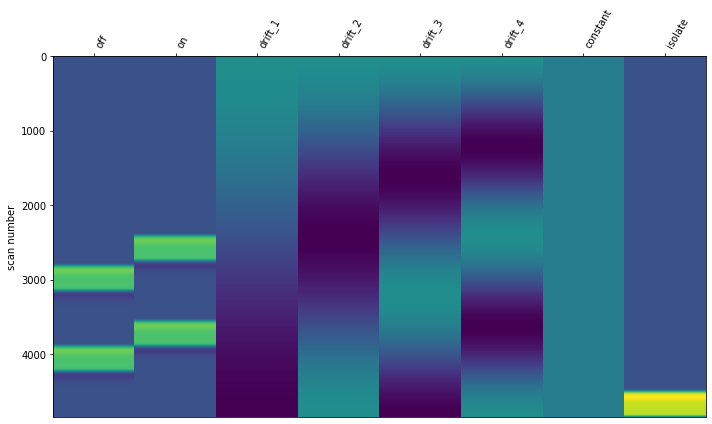

In [213]:
num_annotations = len(annotations)
print(f"{num_annotations = }")
features = []
for i in range(num_annotations):
    including = annotations[i:i+1]
    including_raw_haemo = paul_raw_haemo.copy()
    including_raw_haemo.set_annotations(including)
    including_design_matrix = make_first_level_design_matrix(including_raw_haemo,
                                               drift_model='cosine',
#                                                high_pass=0.005,  # Must be specified per experiment
                                                high_pass=high_pass,
                                               hrf_model='spm',
                                               stim_dur=stim_dur)
#     fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
#     fig = plot_design_matrix(including_design_matrix, ax=ax1)
    first_col_name = including_design_matrix.columns[0]
    print(f"{first_col_name = }")
    
    excluding = annotations[:i] + annotations[i+1:]
    excluding_raw_haemo = paul_raw_haemo.copy()
    excluding_raw_haemo.set_annotations(excluding)
    excluding_design_matrix = make_first_level_design_matrix(excluding_raw_haemo,
                                               drift_model='cosine',
#                                                high_pass=0.005,  # Must be specified per experiment
                                                high_pass=high_pass,
                                               hrf_model='spm',
#                                                stim_dur=5.0,
                                                stim_dur=stim_dur
                                                            )
    excluding_design_matrix["isolate"] = including_design_matrix[first_col_name]
    fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
    fig = plot_design_matrix(excluding_design_matrix, ax=ax1)
    glm_est = run_glm(paul_raw_haemo, excluding_design_matrix)
    glm_est_df = glm_est.to_dataframe()
    
    isolated = glm_est_df[glm_est_df["Condition"] == "isolate"]
    thetas = isolated["theta"].values
    features.append(thetas)
#     break

features = np.array(features)
features.shape

In [224]:
from sklearn.model_selection import train_test_split
from sklearn import svm

X = features.copy()

y = np.array([int(x["description"] == "on") for x in annotations])
y 

array([1, 0, 1, 0, 1])

In [225]:
X.shape, y.shape

((5, 32), (5,))

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape)
pipe = make_pipeline(StandardScaler(), svm.SVC())
pipe.fit(X_train, y_train)
pipe.predict(X_test), y_test, pipe.score(X_test, y_test)

(3, 32) (2, 32)


(array([1, 1]), array([0, 1]), 0.5)

In [257]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X_train = min_max_scaler.fit_transform(X_train)
scaled_X_test = min_max_scaler.fit_transform(X_test)
clf = svm.SVC().fit(scaled_X_train, y_train)
clf.score(scaled_X_test, y_test), clf.predict(scaled_X_test)


(0.5, array([1, 1]))

In [281]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=104)
scaler = StandardScaler()
# Fit on training set.
scaler.fit(X_train)

# Transform both the training set and the test set.
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

neigh = KNeighborsClassifier(n_neighbors=len(X_train))
neigh.fit(scaled_X_train, y_train)
neigh.score(scaled_X_test, y_test)

0.5

In [272]:
scaled_X_train.mean(axis=0), scaled_X_train.std(axis=0)

(array([-5.55111512e-17, -8.32667268e-17,  8.32667268e-17,  0.00000000e+00,
        -8.32667268e-17,  5.55111512e-17,  2.77555756e-17, -1.11022302e-16,
        -2.77555756e-17,  0.00000000e+00, -2.77555756e-17, -5.55111512e-17,
         5.55111512e-17,  0.00000000e+00,  0.00000000e+00, -2.77555756e-17,
         0.00000000e+00,  2.77555756e-17,  2.77555756e-17, -5.55111512e-17,
         5.55111512e-17, -1.11022302e-16,  8.32667268e-17,  5.55111512e-17,
        -5.55111512e-17,  2.77555756e-17, -8.32667268e-17,  2.77555756e-17,
        -5.55111512e-17, -5.55111512e-17, -5.55111512e-17, -2.77555756e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [241]:
X_train

array([[ 7.25913828e-05,  4.62622419e-06,  1.00787631e-05,
        -4.68020499e-06, -2.70082582e-04,  1.45689699e-05,
         1.82188481e-04,  8.90208327e-05,  6.41320882e-05,
         1.46337244e-04,  8.75117008e-05,  3.65685815e-05,
        -1.38981513e-04, -3.73714074e-04, -2.44514135e-04,
        -1.75179493e-04,  6.33068267e-05,  5.79993019e-05,
         3.27650949e-05,  3.87110895e-05, -4.84209216e-05,
         4.84421629e-05, -1.69438734e-05,  4.79801864e-05,
         8.54194198e-05,  6.10169821e-05, -2.28393161e-04,
        -2.15430963e-04,  5.54555911e-05,  8.08973248e-05,
         2.21908528e-04,  1.61172510e-04],
       [-9.59555022e-05, -1.78191946e-05, -1.13963090e-05,
         7.88926761e-06,  3.27964758e-04, -1.74885153e-05,
        -2.36228527e-04, -1.19281578e-04, -8.82399535e-05,
        -1.93604397e-04, -1.19313099e-04, -5.23265757e-05,
         1.62312968e-04,  4.58392358e-04,  3.07013188e-04,
         2.16390584e-04, -7.83397566e-05, -6.38221883e-05,
        -4.17

In [233]:
glm_est_df

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,constant,8.0,3.386880e-08,0.002130,0.000013,4.453332,0.000059,1,1,hbo,True,S1_D1 hbo
1,drift_1,8.0,3.386880e-08,0.359674,0.000884,0.971668,0.000859,1,1,hbo,False,S1_D1 hbo
2,drift_2,8.0,3.386880e-08,0.000013,0.000770,9.447649,0.007278,1,1,hbo,True,S1_D1 hbo
3,drift_3,8.0,3.386880e-08,0.000025,0.000785,8.648927,0.006793,1,1,hbo,True,S1_D1 hbo
4,drift_4,8.0,3.386880e-08,0.000026,0.000731,8.589699,0.006275,1,1,hbo,True,S1_D1 hbo
...,...,...,...,...,...,...,...,...,...,...,...,...
251,drift_3,8.0,5.188664e-08,0.004628,0.002877,3.887119,0.011182,4,8,hbr,True,S4_D8 hbr
252,drift_4,8.0,5.188664e-08,0.001323,0.002656,4.818789,0.012799,4,8,hbr,True,S4_D8 hbr
253,isolate,8.0,5.188664e-08,0.282027,0.000203,-1.153433,-0.000234,4,8,hbr,False,S4_D8 hbr
254,off,8.0,5.188664e-08,0.713150,0.000122,-0.380961,-0.000046,4,8,hbr,False,S4_D8 hbr


256 rows comes from 32 channels * 8 predictors each

In [234]:
isolated = glm_est_df[glm_est_df["Condition"] == "isolate"]
isolated

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
5,isolate,8.0,3.386880e-08,0.064123,0.000055,-2.146512,-0.000119,1,1,hbo,False,S1_D1 hbo
21,isolate,8.0,7.556260e-09,0.884181,0.000212,-0.150388,-0.000032,1,2,hbo,False,S1_D2 hbo
37,isolate,8.0,4.600301e-09,0.808458,0.000089,-0.250575,-0.000022,1,3,hbo,False,S1_D3 hbo
53,isolate,8.0,6.910645e-09,0.891438,0.000028,-0.140893,-0.000004,1,4,hbo,False,S1_D4 hbo
69,isolate,8.0,1.140287e-09,0.003299,0.000082,4.129832,0.000340,2,1,hbo,True,S2_D1 hbo
85,isolate,8.0,2.786703e-08,0.402281,0.000041,-0.884392,-0.000036,2,2,hbo,False,S2_D2 hbo
101,isolate,8.0,7.569117e-09,0.046885,0.000114,-2.347215,-0.000268,2,3,hbo,True,S2_D3 hbo
117,isolate,8.0,2.803313e-08,0.050344,0.000065,-2.301608,-0.000149,2,4,hbo,False,S2_D4 hbo
133,isolate,8.0,2.222744e-08,0.184616,0.000080,-1.451807,-0.000117,3,5,hbo,False,S3_D5 hbo
149,isolate,8.0,6.430077e-08,0.211405,0.000170,-1.358386,-0.000231,3,6,hbo,False,S3_D6 hbo


In [212]:
isolated["theta"].values

array([-9.59555022e-05, -1.78191946e-05, -1.13963090e-05,  7.88926761e-06,
        3.27964758e-04, -1.74885153e-05, -2.36228527e-04, -1.19281578e-04,
       -8.82399535e-05, -1.93604397e-04, -1.19313099e-04, -5.23265757e-05,
        1.62312968e-04,  4.58392358e-04,  3.07013188e-04,  2.16390584e-04,
       -7.83397566e-05, -6.38221883e-05, -4.17411040e-05, -4.77362159e-05,
        5.18487586e-05, -5.47228993e-05,  3.60807695e-05, -5.14802610e-05,
       -8.59764893e-05, -4.83291982e-05,  2.98797453e-04,  2.75413848e-04,
       -6.03439349e-05, -9.04195096e-05, -2.69213972e-04, -2.05007375e-04])

In [209]:
len(isolated)

32

In [205]:
32*8

256

In [204]:
excluding_design_matrix.shape

(4841, 8)

In [194]:
design_matrix.shape

(2082, 33)

In [196]:
len(paul_raw_haemo.times)

4841

In [198]:
len(including_raw_haemo.times)

4841

In [177]:
including_design_matrix.columns[0]

'on'

In [171]:
i = 3
annotations[:i] + annotations[i+1:]

<Annotations | 4 segments: off (1), on (3)>

In [199]:
test.times

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.838e+02, 4.839e+02,
       4.840e+02])

In [201]:
len(raw_intensity.times)

2082